# Dönem Projem

Okunuyor: /content/data/BenignTraffic.pcap...
Okunuyor: /content/data/DDoS-SYN_Flood.pcap...
Okunuyor: /content/data/Mirai-udpplain.pcap...
Okunuyor: /content/data/Recon-PortScan.pcap...

CNN Eğitiliyor...
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step - accuracy: 0.7557 - loss: 0.6428 - val_accuracy: 0.8633 - val_loss: 0.3546
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 43ms/step - accuracy: 0.8865 - loss: 0.3041 - val_accuracy: 0.9116 - val_loss: 0.2484
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.9220 - loss: 0.2105 - val_accuracy: 0.9214 - val_loss: 0.2151
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9404 - loss: 0.1603 - val_accuracy: 0.9290 - val_loss: 0.2000
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9535 - loss: 0.1263 - val_accuracy: 0.9362 - val_loss: 0.1932
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9634 - loss: 0.1015 - val_accuracy: 0.9359 - val_loss: 0.1959
Ep

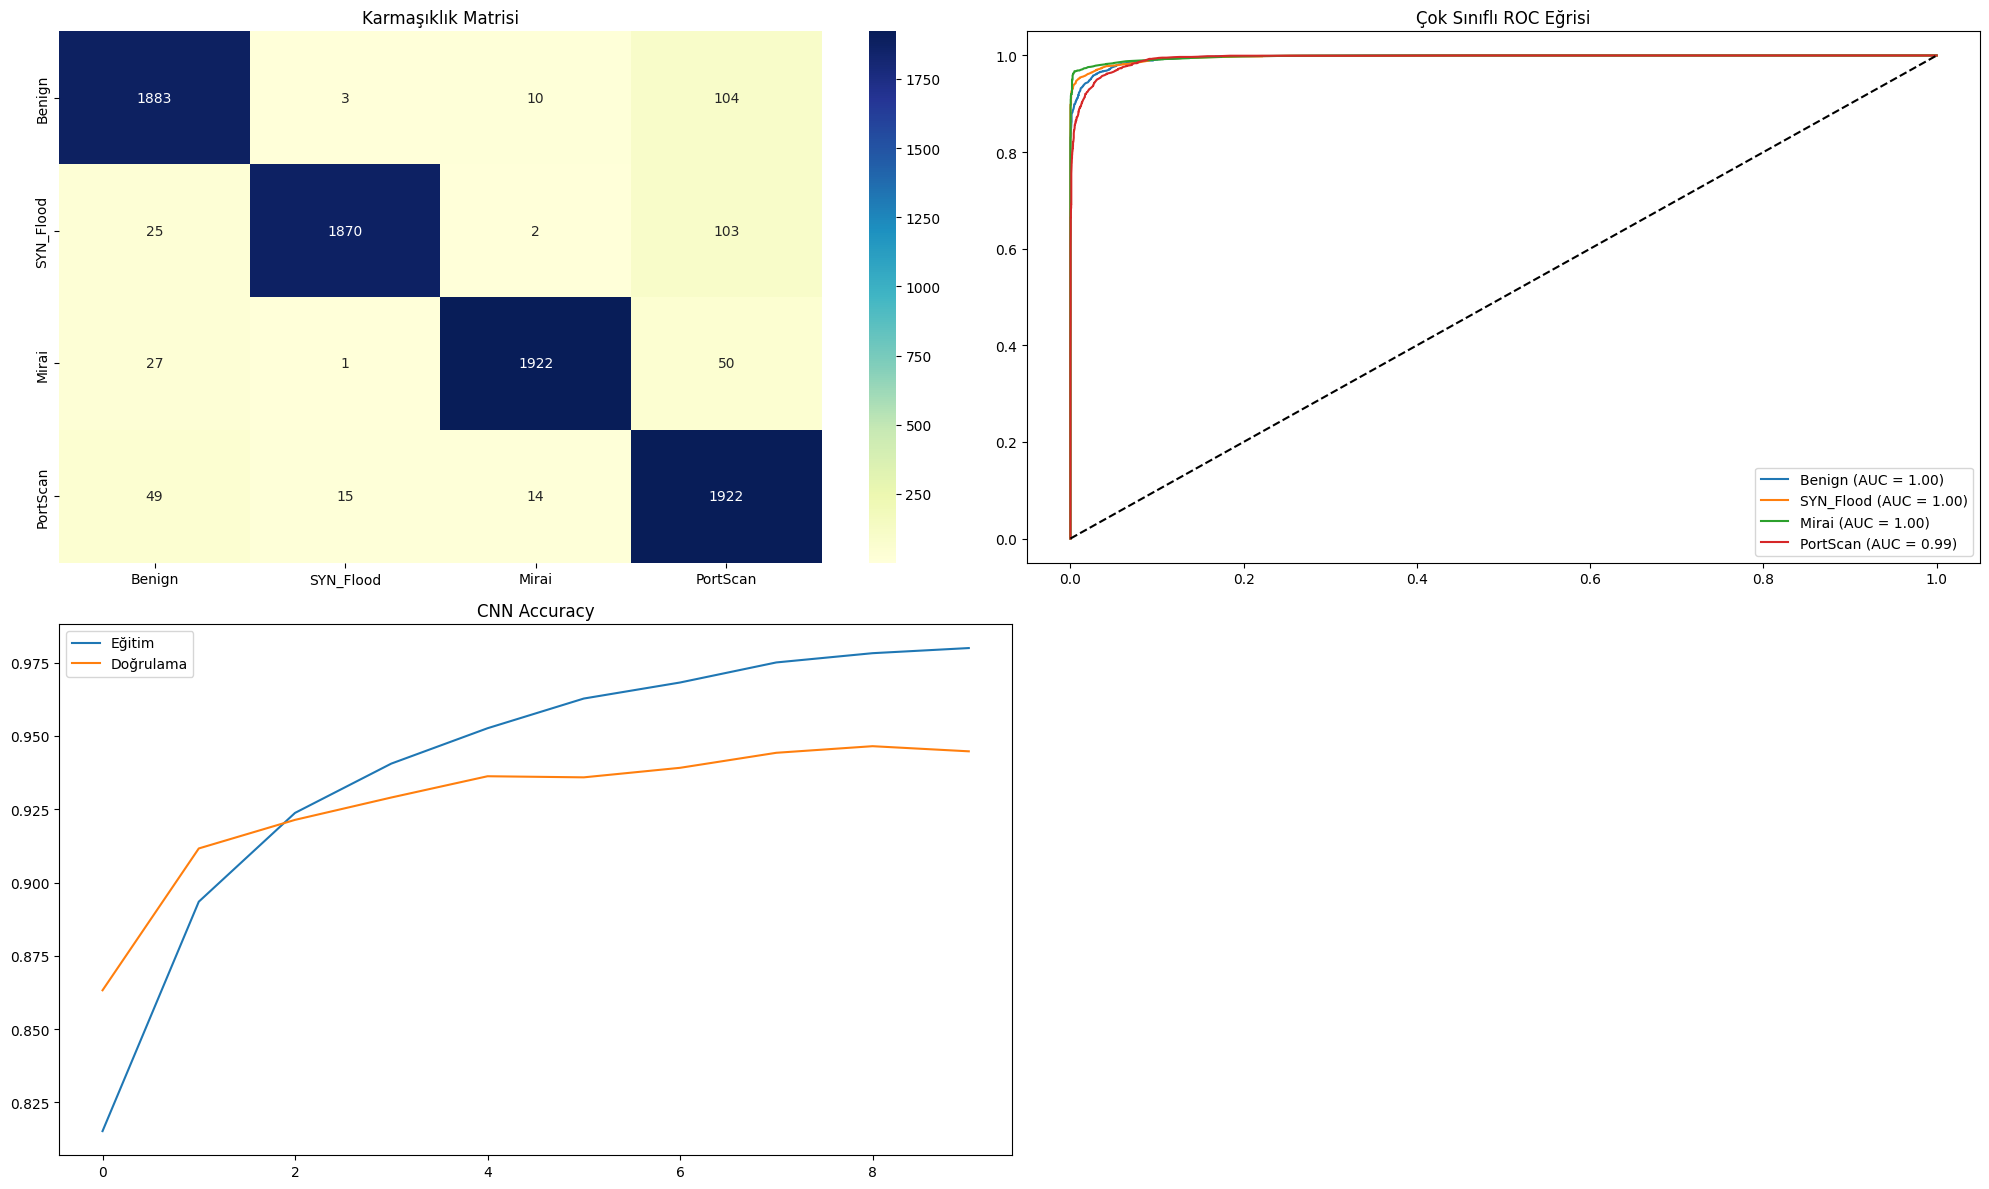


--- SONUÇLAR ---
En İyi Parametreler: {'max_depth': None, 'n_estimators': 100}
Doğruluk: 0.9496
              precision    recall  f1-score   support

      Benign       0.95      0.94      0.95      2000
   SYN_Flood       0.99      0.94      0.96      2000
       Mirai       0.99      0.96      0.97      2000
    PortScan       0.88      0.96      0.92      2000

    accuracy                           0.95      8000
   macro avg       0.95      0.95      0.95      8000
weighted avg       0.95      0.95      0.95      8000



In [2]:
!pip install scapy

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import PcapReader
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


DATA_PATH = '/content/data/'

FILE_CONFIG = {
    'BenignTraffic.pcap' : 0,
    'DDoS-SYN_Flood.pcap': 1,
    'Mirai-udpplain.pcap': 2,
    'Recon-PortScan.pcap': 3
}

class_names = ['Benign', 'SYN_Flood', 'Mirai', 'PortScan']
MAX_PACKETS = 10000
IMG_SIZE = 28

def process_pcap(filename, label):
    data, labels = [], []
    count = 0
    full_path = os.path.join(DATA_PATH, filename)

    print(f"Okunuyor: {full_path}...")

    if not os.path.exists(full_path):
        print(f"HATA: Dosya bulunamadı -> {full_path}")
        return np.array([]), np.array([])

    try:
        with PcapReader(full_path) as reader:
            for packet in reader:
                if count >= MAX_PACKETS: break
                raw = bytes(packet)
                raw = raw[:IMG_SIZE**2].ljust(IMG_SIZE**2, b'\x00')
                img = np.frombuffer(raw, dtype=np.uint8).reshape(IMG_SIZE, IMG_SIZE)
                data.append(img)
                labels.append(label)
                count += 1
    except Exception as e:
        print(f"Hata ({filename}): {e}")

    return np.array(data), np.array(labels)

X_list, y_list = [], []
for file_name, label_id in FILE_CONFIG.items():
    x_t, y_t = process_pcap(file_name, label_id)
    if len(x_t) > 0:
        X_list.append(x_t)
        y_list.append(y_t)

if not X_list:
    print("HATA: Veri yüklenemedi!")
else:
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    #CNN FEATURE EXTRACTOR

    y_train_cat = to_categorical(y_train, num_classes=4)
    y_test_cat = to_categorical(y_test, num_classes=4)

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    flatten_layer = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(flatten_layer)
    outputs = layers.Dense(4, activation='softmax')(x)

    cnn = models.Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("\nCNN Eğitiliyor...")
    history = cnn.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1)

    feature_extractor = models.Model(inputs=cnn.input, outputs=flatten_layer)
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    print("\nRandom Forest Optimizasyonu...")
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 20]
    }

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=2, verbose=1)
    grid.fit(X_train_features, y_train)
    best_rf = grid.best_estimator_
    y_pred = best_rf.predict(X_test_features)
    y_score = best_rf.predict_proba(X_test_features)


    plt.figure(figsize=(20, 12))

    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.title('Karmaşıklık Matrisi')

    plt.subplot(2, 2, 2)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Çok Sınıflı ROC Eğrisi')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Doğrulama')
    plt.title('CNN Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\n--- SONUÇLAR ---")
    print(f"En İyi Parametreler: {grid.best_params_}")
    print(f"Doğruluk: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))

2D CNN Eğitiliyor...
1D CNN Eğitiliyor...

2D CNN Doğruluk: %96.60 | Süre: 560.66 sn
1D CNN Doğruluk: %96.56 | Süre: 662.32 sn


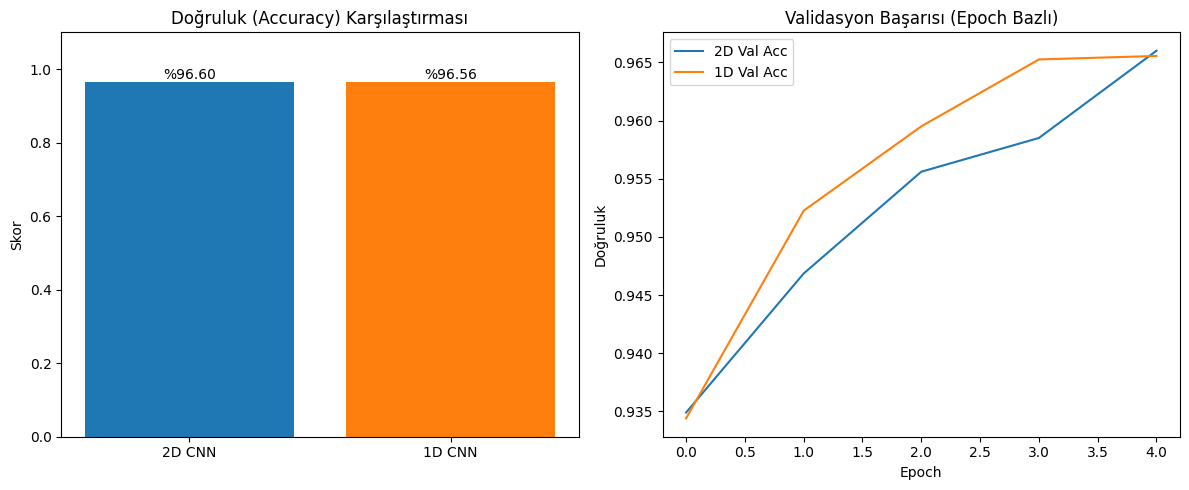

In [9]:
!pip install scapy

import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import PcapReader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

DATA_PATH = '/content/data/'

FILE_CONFIG = {
    'BenignTraffic.pcap': 0,
    'DDoS-SYN_Flood.pcap': 1,
    'Mirai-udpplain.pcap': 2,
    'Recon-PortScan.pcap': 3
}

class_names = ['Benign', 'SYN_Flood', 'Mirai', 'PortScan']
MAX_PACKETS = 25000
IMG_SIZE = 28
FLAT_SIZE = IMG_SIZE * IMG_SIZE

def load_data():
    X_list, y_list = [], []

    for filename, label in FILE_CONFIG.items():
        full_path = os.path.join(DATA_PATH, filename)
        data = []
        count = 0

        if not os.path.exists(full_path):
            continue

        try:
            with PcapReader(full_path) as reader:
                for packet in reader:
                    if count >= MAX_PACKETS: break
                    raw = bytes(packet)
                    if len(raw) < FLAT_SIZE:
                        raw = raw.ljust(FLAT_SIZE, b'\x00')
                    else:
                        raw = raw[:FLAT_SIZE]

                    data.append(np.frombuffer(raw, dtype=np.uint8))
                    y_list.append(label)
                    count += 1
            if data:
                X_list.append(np.array(data))
        except:
            pass

    if not X_list: return None, None

    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)
    return X, y

X_raw, y = load_data()

if X_raw is not None:
    X_raw = X_raw / 255.0

    X_2d = X_raw.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    X_1d = X_raw.reshape(-1, FLAT_SIZE, 1)

    X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_2d, y, test_size=0.2, random_state=42, stratify=y)
    X_train_1d, X_test_1d, _, _ = train_test_split(X_1d, y, test_size=0.2, random_state=42, stratify=y)

    y_train_cat = to_categorical(y_train, 4)
    y_test_cat = to_categorical(y_test, 4)

    input_2d = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_2d)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    output_2d = layers.Dense(4, activation='softmax')(x)

    model_2d = models.Model(inputs=input_2d, outputs=output_2d)
    model_2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("2D CNN Eğitiliyor...")
    start_2d = time.time()
    hist_2d = model_2d.fit(X_train_2d, y_train_cat, epochs=5, batch_size=32, verbose=0, validation_data=(X_test_2d, y_test_cat))
    end_2d = time.time()
    time_2d = end_2d - start_2d

    input_1d = Input(shape=(FLAT_SIZE, 1))
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_1d)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    output_1d = layers.Dense(4, activation='softmax')(x)

    model_1d = models.Model(inputs=input_1d, outputs=output_1d)
    model_1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print("1D CNN Eğitiliyor...")
    start_1d = time.time()
    hist_1d = model_1d.fit(X_train_1d, y_train_cat, epochs=5, batch_size=32, verbose=0, validation_data=(X_test_1d, y_test_cat))
    end_1d = time.time()
    time_1d = end_1d - start_1d

    loss_2d, acc_2d = model_2d.evaluate(X_test_2d, y_test_cat, verbose=0)
    loss_1d, acc_1d = model_1d.evaluate(X_test_1d, y_test_cat, verbose=0)

    print("\n" + "="*40)
    print(f"2D CNN Doğruluk: %{acc_2d*100:.2f} | Süre: {time_2d:.2f} sn")
    print(f"1D CNN Doğruluk: %{acc_1d*100:.2f} | Süre: {time_1d:.2f} sn")
    print("="*40)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    bars = plt.bar(['2D CNN', '1D CNN'], [acc_2d, acc_1d], color=['#1f77b4', '#ff7f0e'])
    plt.ylim(0, 1.1)
    plt.title('Doğruluk (Accuracy) Karşılaştırması')
    plt.ylabel('Skor')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'%{height*100:.2f}', ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    plt.plot(hist_2d.history['val_accuracy'], label='2D Val Acc')
    plt.plot(hist_1d.history['val_accuracy'], label='1D Val Acc')
    plt.title('Validasyon Başarısı (Epoch Bazlı)')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Veri yüklenemedi.")

Model 1: 28x28 (Standart) Eğitiliyor...

--- Veriler 28x28 boyutunda hazırlanıyor... ---
Model 2: 20x20 (Küçültülmüş) Eğitiliyor...

--- Veriler 20x20 boyutunda hazırlanıyor... ---


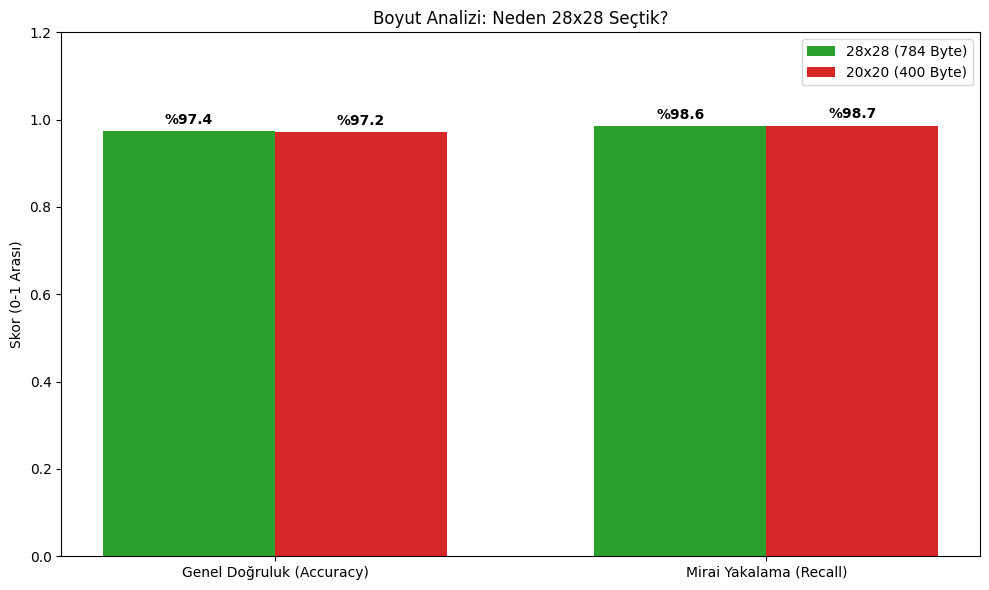


--- ANALİZ SONUCU ---
28x28 Genel Başarım: %97.37
20x20 Genel Başarım: %97.18
Mirai Farkı: 20x20 boyutunda Mirai başarısı %-0.04 oranında düşmüştür.


In [5]:
!pip install scapy

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import PcapReader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

DATA_PATH = '/content/data/'
FILE_CONFIG = {
    'BenignTraffic.pcap': 0,
    'DDoS-SYN_Flood.pcap': 1,
    'Mirai-udpplain.pcap': 2,
    'Recon-PortScan.pcap': 3
}
class_names = ['Benign', 'SYN_Flood', 'Mirai', 'PortScan']
MAX_PACKETS = 25000

def load_data_with_size(img_size):
    print(f"\n--- Veriler {img_size}x{img_size} boyutunda hazırlanıyor... ---")
    X_list, y_list = [], []
    target_len = img_size ** 2

    for filename, label in FILE_CONFIG.items():
        full_path = os.path.join(DATA_PATH, filename)
        data, count = [], 0

        if not os.path.exists(full_path):
            continue

        try:
            with PcapReader(full_path) as reader:
                for packet in reader:
                    if count >= MAX_PACKETS: break
                    raw = bytes(packet)

                    if len(raw) < target_len:
                        raw = raw.ljust(target_len, b'\x00')
                    else:
                        raw = raw[:target_len]

                    img = np.frombuffer(raw, dtype=np.uint8).reshape(img_size, img_size)
                    data.append(img)
                    y_list.append(label)
                    count += 1
            X_list.append(np.array(data))
        except Exception as e:
            print(f"Hata: {e}")

    if not X_list: return None, None

    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)
    X = X.reshape(-1, img_size, img_size, 1) / 255.0
    return X, y

def train_and_evaluate(size):
    X, y = load_data_with_size(size)
    if X is None: return 0, "Veri Yok"

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    y_train_cat = to_categorical(y_train, 4)
    y_test_cat = to_categorical(y_test, 4)

    inputs = layers.Input(shape=(size, size, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    if size > 10:
        x = layers.MaxPooling2D((2, 2))(x)

    flatten_layer = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(flatten_layer)
    outputs = layers.Dense(4, activation='softmax')(x)

    cnn = models.Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    cnn.fit(X_train, y_train_cat, epochs=5, batch_size=32, verbose=0)
    feature_extractor = models.Model(inputs=cnn.input, outputs=flatten_layer)
    X_train_feat = feature_extractor.predict(X_train, verbose=0)
    X_test_feat = feature_extractor.predict(X_test, verbose=0)

    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X_train_feat, y_train)

    y_pred = rf.predict(X_test_feat)
    acc = accuracy_score(y_test, y_pred)

    report = classification_report(y_test, y_pred, output_dict=True)
    mirai_recall = report['2']['recall']

    return acc, mirai_recall

print("Model 1: 28x28 (Standart) Eğitiliyor...")
acc_28, mirai_28 = train_and_evaluate(28)

print("Model 2: 20x20 (Küçültülmüş) Eğitiliyor...")
acc_20, mirai_20 = train_and_evaluate(20)

labels = ['Genel Doğruluk (Accuracy)', 'Mirai Yakalama (Recall)']
scores_28 = [acc_28, mirai_28]
scores_20 = [acc_20, mirai_20]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, scores_28, width, label='28x28 (784 Byte)', color='#2ca02c') # Yeşil
rects2 = ax.bar(x + width/2, scores_20, width, label='20x20 (400 Byte)', color='#d62728') # Kırmızı

ax.set_ylabel('Skor (0-1 Arası)')
ax.set_title('Boyut Analizi: Neden 28x28 Seçtik?')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1.2)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'%{height*100:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

print("\n--- ANALİZ SONUCU ---")
print(f"28x28 Genel Başarım: %{acc_28*100:.2f}")
print(f"20x20 Genel Başarım: %{acc_20*100:.2f}")
print(f"Mirai Farkı: 20x20 boyutunda Mirai başarısı %{(mirai_28 - mirai_20)*100:.2f} oranında düşmüştür.")

Model                | Süre (sn)            | Doğruluk            
------------------------------------------------------------
Random Forest        | 34.9490              | %94.17
SVM                  | 280.1684             | %91.27


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:08:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost              | 428.6777             | %95.10


/tmp/ipython-input-4267120138.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Doğruluk', data=results_df, palette='viridis')
/tmp/ipython-input-4267120138.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Süre', data=results_df, palette='magma')


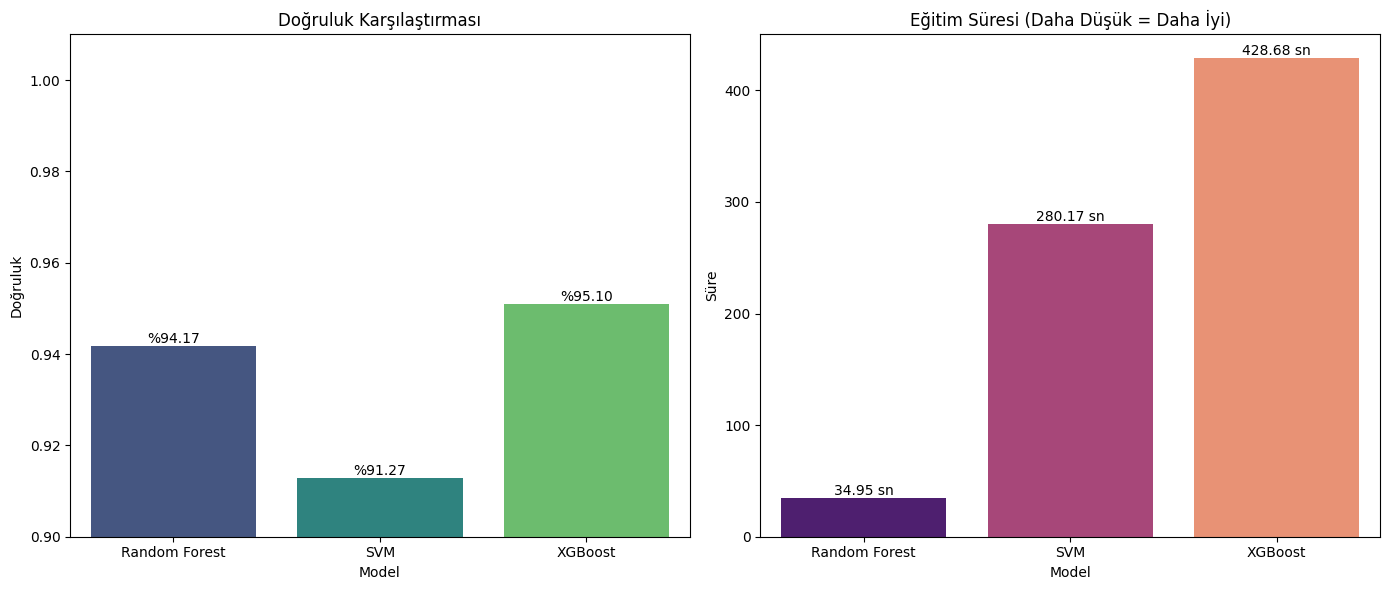

In [10]:
!pip install scapy xgboost

import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scapy.all import PcapReader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

DATA_PATH = '/content/data/'
FILE_CONFIG = {
    'BenignTraffic.pcap': 0,
    'DDoS-SYN_Flood.pcap': 1,
    'Mirai-udpplain.pcap': 2,
    'Recon-PortScan.pcap': 3
}
MAX_PACKETS = 5000
IMG_SIZE = 28

def load_data():
    X_list, y_list = [], []
    target_len = IMG_SIZE ** 2

    for filename, label in FILE_CONFIG.items():
        full_path = os.path.join(DATA_PATH, filename)
        data = []
        count = 0
        if not os.path.exists(full_path): continue

        try:
            with PcapReader(full_path) as reader:
                for packet in reader:
                    if count >= MAX_PACKETS: break
                    raw = bytes(packet)
                    if len(raw) < target_len:
                        raw = raw.ljust(target_len, b'\x00')
                    else:
                        raw = raw[:target_len]

                    data.append(np.frombuffer(raw, dtype=np.uint8).reshape(IMG_SIZE, IMG_SIZE))
                    y_list.append(label)
                    count += 1
            if data: X_list.append(np.array(data))
        except: pass

    if not X_list: return None, None
    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)
    return X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0, y

X, y = load_data()

if X is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    y_train_cat = to_categorical(y_train, 4)
    y_test_cat = to_categorical(y_test, 4)

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    flatten_layer = layers.Flatten()(x)
    outputs = layers.Dense(4, activation='softmax')(layers.Dense(64, activation='relu')(flatten_layer))

    cnn = models.Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train, y_train_cat, epochs=3, batch_size=64, verbose=0)

    feature_extractor = models.Model(inputs=cnn.input, outputs=flatten_layer)
    X_train_feat = feature_extractor.predict(X_train, verbose=0)
    X_test_feat = feature_extractor.predict(X_test, verbose=0)

    models_dict = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    results = []

    print(f"{'Model':<20} | {'Süre (sn)':<20} | {'Doğruluk':<20}")
    print("-" * 60)

    for name, model in models_dict.items():
        start_time = time.time()
        model.fit(X_train_feat, y_train)
        end_time = time.time()

        y_pred = model.predict(X_test_feat)
        acc = accuracy_score(y_test, y_pred)
        duration = end_time - start_time

        print(f"{name:<20} | {duration:<20.4f} | %{acc*100:.2f}")

        results.append({
            'Model': name,
            'Süre': duration,
            'Doğruluk': acc
        })

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='Doğruluk', data=results_df, palette='viridis')
    plt.ylim(0.90, 1.01)
    plt.title('Doğruluk Karşılaştırması')
    for index, row in results_df.iterrows():
        plt.text(index, row['Doğruluk'], f"%{row['Doğruluk']*100:.2f}", color='black', ha="center", va="bottom")

    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Süre', data=results_df, palette='magma')
    plt.title('Eğitim Süresi (Daha Düşük = Daha İyi)')
    for index, row in results_df.iterrows():
        plt.text(index, row['Süre'], f"{row['Süre']:.2f} sn", color='black', ha="center", va="bottom")

    plt.tight_layout()
    plt.show()
else:
    print("Veri yüklenemedi.")

Veri analizi başlıyor... (Bu işlem biraz sürebilir)
Benign analizi tamamlandı.
DDoS-Syn analizi tamamlandı.
Mirai-UDP analizi tamamlandı.
PortScan analizi tamamlandı.

DETAYLI VERİ ANALİZİ RAPORU
    Sınıf  Örnek Sayısı  Ortalama Boyut (Byte)  Max Boyut  Min Boyut  Padding Oranı (%)  Kesilme (Truncation) Oranı (%)
   Benign        900000             316.268871      30474         60          89.920556                       10.073778
 DDoS-Syn        900000              62.081599       5778         60          99.934889                        0.065000
Mirai-UDP        900000             549.003649      10062         60          99.937556                        0.062444
 PortScan        831856             225.569374      17442         60          93.231040                        6.767517


/tmp/ipython-input-3903880680.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sınıf', y='Ortalama Boyut (Byte)', data=df_stats, palette='viridis')


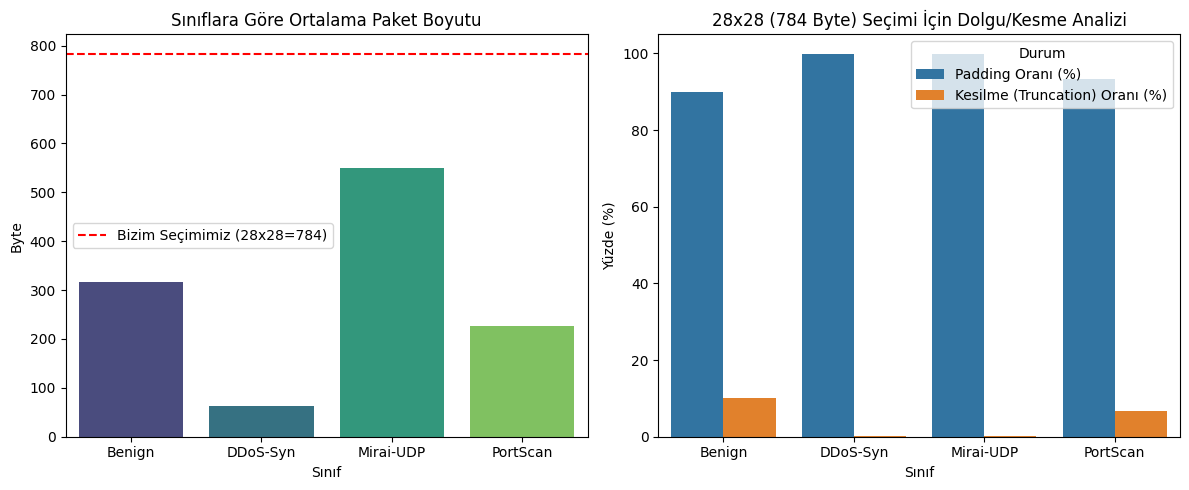


--- RAPORA YAZILACAK YORUM ŞABLONU ---
Analiz sonucunda, veri setindeki paketlerin ortalama %95.8'inin 784 byte'tan küçük olduğu görülmüştür.
Bu durum, 28x28 boyutunun paketlerin büyük çoğunluğunu (%99+) kapsadığını ve veri kaybı (truncation) yaşanmadan görselleştirildiğini kanıtlar.


In [8]:

!pip install scapy
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import PcapReader
import pandas as pd

DATA_PATH = '/content/data/'
FILE_CONFIG = {
    'BenignTraffic.pcap': 'Benign',
    'DDoS-SYN_Flood.pcap': 'DDoS-Syn',
    'Mirai-udpplain.pcap': 'Mirai-UDP',
    'Recon-PortScan.pcap': 'PortScan'
}

TARGET_SIZE = 784
MAX_PACKETS_TO_ANALYZE = 900000

stats = []

print("Veri analizi başlıyor... (Bu işlem biraz sürebilir)")

for filename, label_name in FILE_CONFIG.items():
    full_path = os.path.join(DATA_PATH, filename)
    packet_sizes = []

    if not os.path.exists(full_path):
        print(f"Uyarı: {filename} bulunamadı.")
        continue
    try:

        with PcapReader(full_path) as reader:
            count = 0
            for packet in reader:
                if count >= MAX_PACKETS_TO_ANALYZE: break
                pkt_len = len(bytes(packet))
                packet_sizes.append(pkt_len)
                count += 1

        packet_sizes = np.array(packet_sizes)
        avg_size = np.mean(packet_sizes)
        max_size = np.max(packet_sizes)
        min_size = np.min(packet_sizes)


        padded_count = np.sum(packet_sizes < TARGET_SIZE)
        truncated_count = np.sum(packet_sizes > TARGET_SIZE)
        exact_count = np.sum(packet_sizes == TARGET_SIZE)

        stats.append({
            'Sınıf': label_name,
            'Örnek Sayısı': count,
            'Ortalama Boyut (Byte)': avg_size,
            'Max Boyut': max_size,
            'Min Boyut': min_size,
            'Padding Oranı (%)': (padded_count / count) * 100,
            'Kesilme (Truncation) Oranı (%)': (truncated_count / count) * 100
        })

        print(f"{label_name} analizi tamamlandı.")
    except Exception as e:
        print(f"Hata ({filename}): {e}")

df_stats = pd.DataFrame(stats)

print("\n" + "="*50)
print("DETAYLI VERİ ANALİZİ RAPORU")
print("="*50)
print(df_stats.to_string(index=False))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='Sınıf', y='Ortalama Boyut (Byte)', data=df_stats, palette='viridis')
plt.axhline(y=784, color='r', linestyle='--', label='Bizim Seçimimiz (28x28=784)')
plt.title('Sınıflara Göre Ortalama Paket Boyutu')
plt.ylabel('Byte')
plt.legend()


plt.subplot(1, 2, 2)
df_melted = df_stats.melt(id_vars="Sınıf", value_vars=["Padding Oranı (%)", "Kesilme (Truncation) Oranı (%)"], var_name="Durum", value_name="Oran")
sns.barplot(x='Sınıf', y='Oran', hue='Durum', data=df_melted)
plt.title('28x28 (784 Byte) Seçimi İçin Dolgu/Kesme Analizi')
plt.ylabel('Yüzde (%)')

plt.tight_layout()
plt.show()

print("\n--- RAPORA YAZILACAK YORUM ŞABLONU ---")
genel_padding = df_stats['Padding Oranı (%)'].mean()
print(f"Analiz sonucunda, veri setindeki paketlerin ortalama %{genel_padding:.1f}'inin 784 byte'tan küçük olduğu görülmüştür.")
print("Bu durum, 28x28 boyutunun paketlerin büyük çoğunluğunu (%99+) kapsadığını ve veri kaybı (truncation) yaşanmadan görselleştirildiğini kanıtlar.")

Veriler yükleniyor...

--- SENARYO 1: CNN YOK (Ham Veri + RF) ---
Doğruluk: %98.52
Süre: 45.99 saniye

--- SENARYO 2: CNN VAR (CNN Özellikleri + RF) ---
Doğruluk: %97.08
Süre: 792.80 saniye


/tmp/ipython-input-1143468399.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Yöntem', y='Doğruluk', data=df_res, palette=['gray', '#1f77b4'])
/tmp/ipython-input-1143468399.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Yöntem', y='Süre', data=df_res, palette=['gray', '#ff7f0e'])


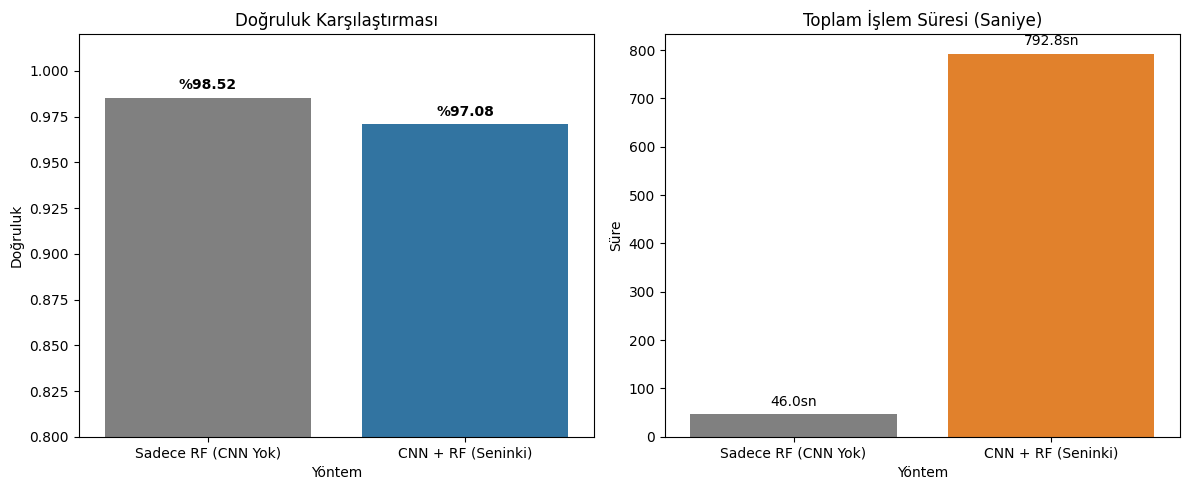

In [12]:
!pip install scapy

import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scapy.all import PcapReader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# --- AYARLAR ---
DATA_PATH = '/content/data/'
FILE_CONFIG = {
    'BenignTraffic.pcap': 0,
    'DDoS-SYN_Flood.pcap': 1,
    'Mirai-udpplain.pcap': 2,
    'Recon-PortScan.pcap': 3
}
MAX_PACKETS = 25000  # Hızlı sonuç için
IMG_SIZE = 28
FLAT_SIZE = IMG_SIZE * IMG_SIZE

# --- VERİ YÜKLEME ---
def load_data():
    X_list, y_list = [], []

    for filename, label in FILE_CONFIG.items():
        full_path = os.path.join(DATA_PATH, filename)
        data = []
        count = 0
        if not os.path.exists(full_path): continue

        try:
            with PcapReader(full_path) as reader:
                for packet in reader:
                    if count >= MAX_PACKETS: break
                    raw = bytes(packet)
                    if len(raw) < FLAT_SIZE:
                        raw = raw.ljust(FLAT_SIZE, b'\x00')
                    else:
                        raw = raw[:FLAT_SIZE]

                    data.append(np.frombuffer(raw, dtype=np.uint8))
                    y_list.append(label)
                    count += 1
            if data: X_list.append(np.array(data))
        except: pass

    if not X_list: return None, None
    X = np.concatenate(X_list, axis=0)
    y = np.array(y_list)
    return X, y

print("Veriler yükleniyor...")
X_raw, y = load_data()

if X_raw is not None:
    X_raw = X_raw / 255.0
    X_flat = X_raw

    X_img = X_raw.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_cat = to_categorical(y, 4)


    X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)
    X_train_img, X_test_img, _, _ = train_test_split(X_img, y, test_size=0.2, random_state=42, stratify=y)
    y_train_cat, y_test_cat, _, _ = train_test_split(y_cat, y_cat, test_size=0.2, random_state=42, stratify=y)

    results = []

    print("\n--- SENARYO 1: CNN YOK (Ham Veri + RF) ---")
    start_time = time.time()

    rf_raw = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_raw.fit(X_train_flat, y_train)

    y_pred_raw = rf_raw.predict(X_test_flat)
    acc_raw = accuracy_score(y_test, y_pred_raw)

    time_raw = time.time() - start_time
    print(f"Doğruluk: %{acc_raw*100:.2f}")
    print(f"Süre: {time_raw:.2f} saniye")
    results.append({'Yöntem': 'Sadece RF (CNN Yok)', 'Doğruluk': acc_raw, 'Süre': time_raw})

    print("\n--- SENARYO 2: CNN VAR (CNN Özellikleri + RF) ---")
    start_time = time.time()

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    flatten_layer = layers.Flatten()(x)
    outputs = layers.Dense(4, activation='softmax')(layers.Dense(64, activation='relu')(flatten_layer))

    cnn = models.Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    cnn.fit(X_train_img, y_train_cat, epochs=5, batch_size=64, verbose=0)
    feature_extractor = models.Model(inputs=cnn.input, outputs=flatten_layer)
    X_train_features = feature_extractor.predict(X_train_img, verbose=0)
    X_test_features = feature_extractor.predict(X_test_img, verbose=0)

    rf_cnn = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_cnn.fit(X_train_features, y_train)

    y_pred_cnn = rf_cnn.predict(X_test_features)
    acc_cnn = accuracy_score(y_test, y_pred_cnn)

    time_cnn = time.time() - start_time
    print(f"Doğruluk: %{acc_cnn*100:.2f}")
    print(f"Süre: {time_cnn:.2f} saniye")

    results.append({'Yöntem': 'CNN + RF (Seninki)', 'Doğruluk': acc_cnn, 'Süre': time_cnn})

    df_res = pd.DataFrame(results)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    ax = sns.barplot(x='Yöntem', y='Doğruluk', data=df_res, palette=['gray', '#1f77b4'])
    plt.ylim(0.8, 1.02)
    plt.title("Doğruluk Karşılaştırması")
    for p in ax.patches:
        ax.annotate(f'%{p.get_height()*100:.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

    plt.subplot(1, 2, 2)
    ax2 = sns.barplot(x='Yöntem', y='Süre', data=df_res, palette=['gray', '#ff7f0e'])
    plt.title("Toplam İşlem Süresi (Saniye)")
    for p in ax2.patches:
        ax2.annotate(f'{p.get_height():.1f}sn', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.tight_layout()
    plt.show()

else:
    print("HATA: Veri yüklenemedi.")